i=0, L=0.80, U=1.20, angle_rot=13.293 deg, color_g=[0.80,1.19], shape_g=[0.80,1.20]
i=1, L=0.82, U=1.18, angle_rot=12.118 deg, color_g=[0.82,1.18], shape_g=[0.82,1.18]
i=2, L=0.84, U=1.16, angle_rot=10.797 deg, color_g=[0.84,1.16], shape_g=[0.84,1.16]
i=3, L=0.86, U=1.14, angle_rot=9.503 deg, color_g=[0.86,1.14], shape_g=[0.86,1.14]
i=4, L=0.88, U=1.12, angle_rot=8.179 deg, color_g=[0.88,1.12], shape_g=[0.88,1.12]
i=5, L=0.90, U=1.10, angle_rot=6.929 deg, color_g=[0.90,1.10], shape_g=[0.90,1.10]
i=6, L=0.92, U=1.08, angle_rot=5.679 deg, color_g=[0.92,1.08], shape_g=[0.92,1.08]
i=7, L=0.94, U=1.06, angle_rot=4.402 deg, color_g=[0.94,1.06], shape_g=[0.94,1.06]
i=8, L=0.96, U=1.04, angle_rot=3.073 deg, color_g=[0.96,1.04], shape_g=[0.96,1.04]
i=9, L=0.98, U=1.02, angle_rot=1.635 deg, color_g=[0.98,1.02], shape_g=[0.98,1.02]


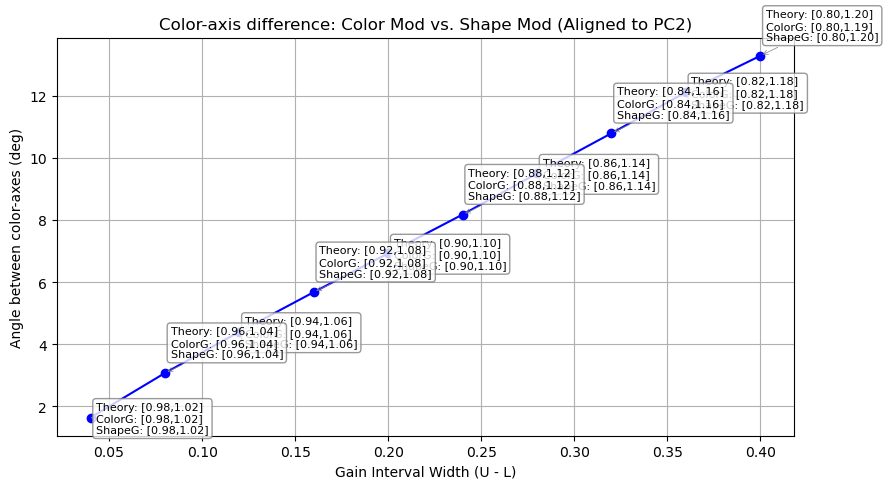

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.optimize import minimize

np.random.seed(15)
N = 300
K = 2  # shape=0, color=1
desired_radius = 0.9
p_high = 0.2
p_low = 0.2

np.random.seed(15)

# -------------------------------------------------
# 1) Initialization
# -------------------------------------------------
def initialize_selectivity_matrix(N, K):
    """
    Half are shape-based, half are color-based, with a random distribution.
    """
    S = np.zeros((N, K))
    S[:N//2, 0] = np.random.rand(N//2)
    S[:N//2, 1] = 0.5 - S[:N//2, 0] / 2
    neg_idx = (S[:N//2, 0] - S[:N//2, 1]) < 0
    S[:N//2, 0][neg_idx] = np.random.uniform(0, 0.5, size=np.sum(neg_idx))
    S[N//2:, 1] = S[:N//2, 0]
    S[N//2:, 0] = S[:N//2, 1]
    return S

def initialize_W_F(S):
    """
    W_F divides each neuron's (shape,color) by its sum.
    """
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        r = np.sum(S[i])
        if r > 0:
            W_F[i] = S[i] / r
        else:
            W_F[i] = S[i]
    return W_F

def initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=0.9):
    """
    Build a recurrent matrix with four blocks and scale it.
    """
    W_R = np.zeros((N, N))
    halfN = N // 2

    ss_mask = np.random.rand(halfN, halfN) < p_high
    W_R[:halfN, :halfN][ss_mask] = np.random.rand(np.sum(ss_mask)) * 0.1

    sc_mask = np.random.rand(halfN, N - halfN) < p_low
    W_R[:halfN, halfN:][sc_mask] = np.random.rand(np.sum(sc_mask)) * 0.1

    cs_mask = np.random.rand(N - halfN, halfN) < p_low
    W_R[halfN:, :halfN][cs_mask] = np.random.rand(np.sum(cs_mask)) * 0.1

    cc_mask = np.random.rand(N - halfN, N - halfN) < p_high
    W_R[halfN:, halfN:][cc_mask] = np.random.rand(np.sum(cc_mask)) * 0.1

    np.fill_diagonal(W_R, 0)

    if WR_tuned:
        thresh = 0.2
        for i in range(N):
            for j in range(N):
                if i != j:
                    d = np.linalg.norm(S[i] - S[j])
                    if d < thresh:
                        W_R[i, j] *= (2 - d / thresh)

    # Rescale W_R so spectral radius = desired_radius
    eivals = np.linalg.eigvals(W_R)
    max_ev = np.max(np.abs(eivals))
    if max_ev > 0:
        W_R *= (desired_radius / max_ev)
    return W_R

# -------------------------------------------------
# 2) Response Computations
# -------------------------------------------------
def compute_response(W_R, W_F, shape_val, color_val, g_vector=None):
    """
    Returns steady-state response for a single (shape_val, color_val).
    """
    I = np.eye(W_R.shape[0])
    if g_vector is None:
        inv_mat = np.linalg.inv(I - W_R)
        WF_eff = W_F
    else:
        G = np.diag(g_vector)
        inv_mat = np.linalg.inv(I - G @ W_R)
        WF_eff = G @ W_F

    F = np.array([shape_val, color_val])
    return inv_mat @ (WF_eff @ F)

def compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None):
    """
    Returns a [num_shape * num_color, N] array of responses
    by scanning over shape_vals x color_vals.
    """
    responses = []
    for s in shape_vals:
        for c in color_vals:
            resp = compute_response(W_R, W_F, s, c, g_vector)
            responses.append(resp)
    return np.array(responses)

# Define color axis for shape=0.3
def color_axis_direction(W_R, W_F, g, shape_fixed=0.3):
    """
    For a given g-vector, define color-axis as:
       r(shape=shape_fixed, color=1) - r(shape=shape_fixed, color=0).
    """
    resp_c0 = compute_response(W_R, W_F, shape_fixed, 0.0, g)
    resp_c1 = compute_response(W_R, W_F, shape_fixed, 1.0, g)
    return resp_c1 - resp_c0

# Define shape axis for color=0.3
def shape_axis_direction(W_R, W_F, g, color_fixed=0.3):
    """
    For a given g-vector, define shape-axis as:
       r(shape=1, color=color_fixed) - r(shape=0, color=color_fixed).
    """
    resp_s0 = compute_response(W_R, W_F, 0.0, color_fixed, g)
    resp_s1 = compute_response(W_R, W_F, 1.0, color_fixed, g)
    return resp_s1 - resp_s0

# -------------------------------------------------
# 3) Alignment Objectives
# -------------------------------------------------
def make_alignment_objective(axis_fn, pc_vector):
    """
    axis_fn: function(g) -> vector in R^N (the axis to align with pc_vector).
    pc_vector: the principal component we want to align with.

    We want to maximize cos^2(axis_fn(g), pc_vector).
    => minimize the negative.
    """
    def objective(g):
        d = axis_fn(g)
        denom = np.linalg.norm(d) * np.linalg.norm(pc_vector)
        if denom < 1e-15:
            return 0.0  # degenerate => no angle
        cos_val = np.dot(d, pc_vector) / denom
        cos_val = np.clip(cos_val, -1.0, 1.0)
        return -(cos_val**2)  # we want to maximize cos^2
    return objective

def angle_between_vectors(u, v):
    """
    Return the angle in degrees between vectors u and v,
    in [0..90] if we treat direction flips as identical.
    """
    denom = np.linalg.norm(u) * np.linalg.norm(v)
    if denom < 1e-15:
        return np.nan
    val = np.dot(u, v) / denom
    val = np.clip(val, -1, 1)
    angle_deg = np.degrees(np.arccos(val))
    return min(angle_deg, 180.0 - angle_deg)

# -------------------------------------------------
# MAIN
# -------------------------------------------------
if __name__ == "__main__":
    # 1) Create the network
    S = initialize_selectivity_matrix(N, K)
    W_F = initialize_W_F(S)
    W_R = initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=desired_radius)

    # 2) PCA on the unmodulated grid (11x11)
    grid_points = 11
    shape_vals = np.linspace(0, 1, grid_points)
    color_vals = np.linspace(0, 1, grid_points)

    responses_grid_unmod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None)
    pca_grid = PCA(n_components=3)
    pca_grid.fit(responses_grid_unmod)

    # --- Use PC2 instead of PC1 ---
    v2 = pca_grid.components_[1]
    v2 /= np.linalg.norm(v2)  # normalize PC2

    # 3) We'll do a sweep over [L, U] intervals, but with bigger steps
    num_steps = 10  # changed from 20
    all_interval_widths = []
    angle_differences = []  # angle between color-axes under color vs shape modulation
    all_annotations = []
    all_color_axis_colorMod = []
    all_color_axis_shapeMod = []
    all_color_angle_colorMod =[]
    all_color_angle_shapeMod = []

    # Pre-construct objective functions (aligning to v2)
    color_obj = make_alignment_objective(
        axis_fn=lambda g: color_axis_direction(W_R, W_F, g, shape_fixed=0.3),
        pc_vector=v2
    )
    shape_obj = make_alignment_objective(
        axis_fn=lambda g: shape_axis_direction(W_R, W_F, g, color_fixed=0.3),
        pc_vector=v2
    )

    # We'll double the step size by using 0.02 instead of 0.01
    for i in range(num_steps):
        # define the theoretical bounds
        step_val = 0.02  # bigger step
        L = 0.8 + i * step_val
        U = 1.2 - i * step_val

        init_g = np.ones(N)
        bounds = [(L, U)] * N

        # --- 3.1) Color Modulation ---
        res_color = minimize(fun=color_obj,
                             x0=init_g,
                             method='L-BFGS-B',
                             bounds=bounds,
                             options={'maxiter': 200, 'disp': False})
        g_opt_color = res_color.x
        cmin, cmax = np.min(g_opt_color), np.max(g_opt_color)

        # --- 3.2) Shape Modulation ---
        res_shape = minimize(fun=shape_obj,
                             x0=init_g,
                             method='L-BFGS-B',
                             bounds=bounds,
                             options={'maxiter': 200, 'disp': False})
        g_opt_shape = res_shape.x
        smin, smax = np.min(g_opt_shape), np.max(g_opt_shape)

        # --- 3.3) measure color-axis in each final network
        color_axis_colorMod = color_axis_direction(W_R, W_F, g_opt_color, 0.3)
        color_axis_shapeMod = color_axis_direction(W_R, W_F, g_opt_shape, 0.3)

        # Angles relative to PC2
        color_angle_colorMod = angle_between_vectors(color_axis_colorMod, v2)
        color_angle_shapeMod = angle_between_vectors(color_axis_colorMod, v2)

        # The angle between the two color-axes themselves
        angle_rotated = angle_between_vectors(color_axis_colorMod, color_axis_shapeMod)

        # store data
        actual_width = U - L
        all_interval_widths.append(actual_width)
        angle_differences.append(angle_rotated)
        all_color_axis_colorMod.append(color_axis_colorMod)
        all_color_axis_shapeMod.append(color_axis_shapeMod)
        all_color_angle_colorMod.append(color_angle_colorMod)
        all_color_angle_shapeMod.append(color_angle_shapeMod)

        # build multi-line annotation
        note_str = (
            f"Theory: [{L:.2f},{U:.2f}]\n"
            f"ColorG: [{cmin:.2f},{cmax:.2f}]\n"
            f"ShapeG: [{smin:.2f},{smax:.2f}]"
        )
        all_annotations.append(note_str)

        print(f"i={i}, L={L:.2f}, U={U:.2f}, angle_rot={angle_rotated:.3f} deg, "
              f"color_g=[{cmin:.2f},{cmax:.2f}], shape_g=[{smin:.2f},{smax:.2f}]")

    # ---------------------------------------------------------
    # Plot the angle difference vs. interval width
    # ---------------------------------------------------------
    plt.figure(figsize=(9,5))
    x_values = np.array(all_interval_widths)

    plt.plot(x_values, angle_differences, marker='o', color='b')

    # We'll annotate each point with a small offset so they don't overlap too much
    for i, (x, y, txt) in enumerate(zip(x_values, angle_differences, all_annotations)):
        dx = 0.003  # shift right
        dy = 0.5 if (i % 2 == 0) else -0.5  # alternate up/down
        plt.annotate(
            txt,
            xy=(x, y),
            xytext=(x + dx, y + dy),
            textcoords="data",
            arrowprops=dict(arrowstyle="->", lw=0.5, color="gray"),
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )

    plt.xlabel("Gain Interval Width (U - L)")
    plt.ylabel("Angle between color-axes (deg)")
    plt.title("Color-axis difference: Color Mod vs. Shape Mod (Aligned to PC2)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("range_vs_degree.png", dpi=150)
    plt.show()


In [3]:
# ---------------------------------------------------------
# SAVE ALL DATA TO A SINGLE COMPRESSED FILE
# ---------------------------------------------------------
import os

out_filename = "simulation_data_pc2.npz"

# Save everything you want. You can add or remove items as needed.
np.savez_compressed(
    out_filename,
    S=S,                                # Selectivity matrix (N x K)
    W_F=W_F,                            # Feedforward weights (N x K)
    W_R=W_R,                            # Recurrent weight matrix (N x N)
    responses_grid_unmod=responses_grid_unmod,  # grid responses without modulation
    v2=v2,                              # The first principal component vector
    all_interval_widths=np.array(all_interval_widths),
    angle_differences=np.array(angle_differences),
    all_annotations=np.array(all_annotations, dtype=object),
    all_color_axis_colorMod=np.array(all_color_axis_colorMod),
    all_color_axis_shapeMod=np.array(all_color_axis_shapeMod),
    all_color_angle_colorMod=np.array(all_color_angle_colorMod),
    all_color_angle_shapeMod=np.array(all_color_angle_shapeMod),
)

print(f"Data saved to '{out_filename}' (size: {os.path.getsize(out_filename)/1e3:.1f} KB)")


Data saved to 'simulation_data_pc2.npz' (size: 477.6 KB)


In [5]:
# Create a gain vector of all ones
g_all_ones = np.ones(N)

# Compute the default color-axis for shape_fixed=0.3
default_color_axis = color_axis_direction(W_R, W_F, g_all_ones, shape_fixed=0.3)
color_angle_unmod = angle_between_vectors(default_color_axis, v2)
print(color_angle_unmod)
# Convert the list to an array (if it's not already)
color_angle_colorMod_arr = np.array(all_color_angle_colorMod)

# Improvement array, one entry per iteration
# A positive value here means the angle has decreased 
# compared to the unmodulated scenario.
color_mod_improvement = color_angle_unmod - color_angle_colorMod_arr
print(color_mod_improvement)

86.91333723062779
[7.92634429 7.30167603 6.52258913 5.70488681 4.89951685 4.15539846
 3.43309324 2.66782255 1.85990938 0.98897219]


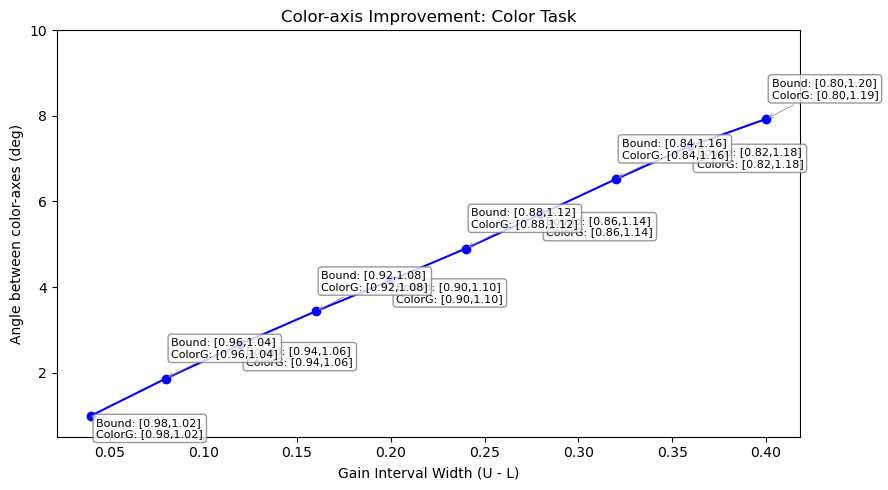

In [11]:
plt.figure(figsize=(9,5))
x_values = np.array(all_interval_widths)

plt.plot(x_values, color_mod_improvement, marker='o', color='b')

all_annotations_simple = []

for old_anno in all_annotations:
    # 1) Change "Theory:" to "Bound:"
    updated = old_anno.replace("Theory:", "Bound:")

    # 2) Remove the line that starts with "ShapeG:"
    lines = updated.split("\n")
    filtered_lines = [ln for ln in lines if not ln.startswith("ShapeG:")]

    # 3) Join what's left (the "Bound:" line + "ColorG:" line)
    new_anno = "\n".join(filtered_lines)

    all_annotations_simple.append(new_anno)


# We'll annotate each point with a small offset so they don't overlap too much
for i, (x, y, txt) in enumerate(zip(x_values, color_mod_improvement, all_annotations_simple)):
        # slight shift in x and y for each data point
        dx = 0.003  # shift right
        dy = 0.5 if (i % 2 == 0) else -0.5  # alternate up/down
        plt.annotate(
            txt,
            xy=(x, y),
            xytext=(x + dx, y + dy),
            textcoords="data",
            arrowprops=dict(arrowstyle="->", lw=0.5, color="gray"),
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
# Draw a horizontal line at color_angle_unmod
plt.axhline(
    y=color_angle_unmod, 
    color='r', 
    linestyle='--', 
    linewidth=1.0, 
    label=f"Unmod angle = {color_angle_unmod:.2f}°"
)

plt.xlabel("Gain Interval Width (U - L)")
plt.ylabel("Angle between color-axes (deg)")
plt.title("Color-axis Improvement: Color Task")
plt.grid(False)
plt.ylim(0.5,10)
plt.tight_layout()
plt.savefig("range_vs_degree_improvement_pc2.png", dpi=150)
plt.show()

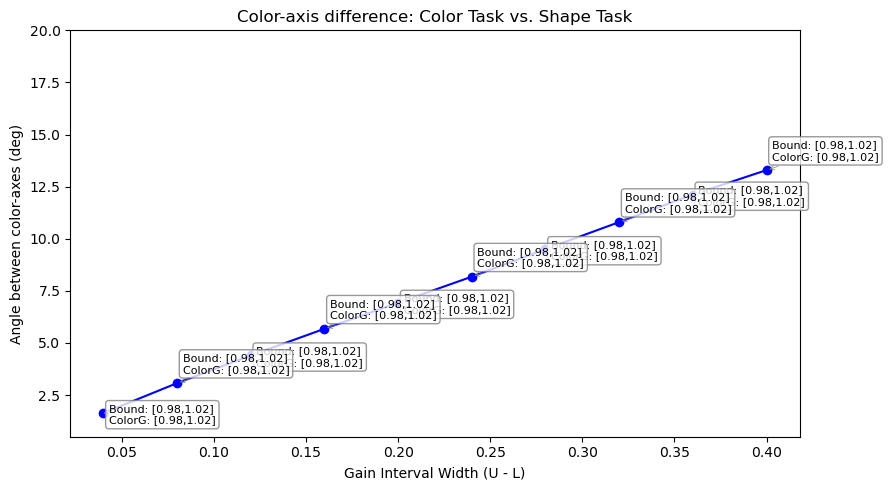

In [12]:
plt.figure(figsize=(9,5))
x_values = np.array(all_interval_widths)

plt.plot(x_values, angle_differences, marker='o', color='b')

all_annotations_complex = []

for old_anno in all_annotations:
    # 1) Change "Theory:" to "Bound:"
    updated = old_anno.replace("Theory:", "Bound:")

    all_annotations_complex.append(new_anno)


# We'll annotate each point with a small offset so they don't overlap too much
for i, (x, y, txt) in enumerate(zip(x_values, angle_differences, all_annotations_complex)):
        # slight shift in x and y for each data point
    dx = 0.003  # shift right
    dy = 0.5 if (i % 2 == 0) else -0.5  # alternate up/down
    plt.annotate(
            txt,
            xy=(x, y),
            xytext=(x + dx, y + dy),
            textcoords="data",
            arrowprops=dict(arrowstyle="->", lw=0.5, color="gray"),
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )

plt.xlabel("Gain Interval Width (U - L)")
plt.ylabel("Angle between color-axes (deg)")
plt.title("Color-axis difference: Color Task vs. Shape Task")
plt.grid(False)
plt.ylim(0.5,20)
plt.tight_layout()
plt.savefig("range_vs_degree_pc2.png", dpi=150)
plt.show()